## Import Libraries

In [3]:
# Updated on 09032024
!pip install hmmlearn
!pip install backtesting
!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=463c605b37da2f9e7f4c6a8ebec8614d4ff82a55767df0c2d9d5c982bfcbbc74
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import yfinance as yf

from hmmlearn.hmm import GaussianHMM
from pykalman import KalmanFilter

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from backtesting.lib import plot_heatmaps

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


## Downward data

In [5]:
spy = yf.download("SPY", start = "2013-01-01", end = "2024-03-08")

[*********************100%%**********************]  1 of 1 completed


In [6]:
spy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,145.110001,146.149994,144.729996,146.059998,119.491982,192059000
2013-01-03,145.990005,146.369995,145.339996,145.729996,119.222046,144761800
2013-01-04,145.970001,146.610001,145.669998,146.369995,119.745590,116817700
2013-01-07,145.850006,146.110001,145.429993,145.970001,119.418404,110002500
2013-01-08,145.710007,145.910004,144.979996,145.550003,119.074783,121265100


In [7]:
# Create a copy
df = spy.copy()
df["Returns"] = np.log(spy['Close']).diff().dropna()
df.dropna(inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2013-01-03,145.990005,146.369995,145.339996,145.729996,119.222046,144761800,-0.002262
2013-01-04,145.970001,146.610001,145.669998,146.369995,119.745590,116817700,0.004382
2013-01-07,145.850006,146.110001,145.429993,145.970001,119.418404,110002500,-0.002736
2013-01-08,145.710007,145.910004,144.979996,145.550003,119.074783,121265100,-0.002881
2013-01-09,145.869995,146.320007,145.639999,145.919998,119.377472,90745600,0.002539


## Train HMM model

In [8]:
# Prepare training data(log return) for HMM
X_train = np.array(df[df.index < "2017-12-31"]["Returns"]).reshape(-1,1)
X_train

array([[-0.00226191],
       [ 0.00438206],
       [-0.0027365 ],
       ...,
       [ 0.00048645],
       [ 0.0020553 ],
       [-0.00377765]])

In [9]:
# Train HMM Model
hmm_model = GaussianHMM(n_components=2, n_iter=100, random_state=42).fit(X_train)
print("Model Score:", hmm_model.score(X_train))

Model Score: 4473.469082660251


In [10]:
# Model parameters
print(f"means : \n {hmm_model.means_}")
print("-----")
print(f"covariance matrix : \n {hmm_model.covars_}")
print("-----")
print(f"transition matrix : \n {hmm_model.transmat_}")

means : 
 [[ 0.00079662]
 [-0.00160688]]
-----
covariance matrix : 
 [[[4.31252264e-05]]

 [[2.56878543e-04]]]
-----
transition matrix : 
 [[0.98820146 0.01179854]
 [0.07738718 0.92261282]]


In [11]:
# state 0 is bull regime, state 1 is bear regime.
# This is because state 0 has positive log return, while that of state 1 is negative
# The transition matrix also tells us that it is more likely to stay in the same regime than switching

In [12]:
# Expected time to stay in the regimes
T_bull = 1 / (1 - hmm_model.transmat_[0][0])
T_bear = 1 / (1 - hmm_model.transmat_[1][1])
print(f"Expected Duration of Bull Regime : {T_bull} trading days")
print(f"Expected Duration of Bear Regime : {T_bear} trading days")
# Observation is difference from the expectation

Expected Duration of Bull Regime : 84.75624272200889 trading days
Expected Duration of Bear Regime : 12.922037347654912 trading days


In [13]:
# Check results
hidden_states = hmm_model.predict(X_train)
# Note that the predict mehod find the most likely sequence by forward-backwards algorithm.
# Should use the forward algorithm to estimate the posterior probability of a state
hidden_states[:5]

array([0, 0, 0, 0, 0])

In [14]:
# Use the forward algorithm to estimate the posterior probability of a state
X= np.array(df["Returns"]).reshape(-1,1)
hidden_states_proba = hmm_model.predict_proba(X)

In [15]:
hidden_states_proba.T

array([[1.00000000e+00, 9.99261724e-01, 9.98892792e-01, ...,
        9.85989601e-01, 9.83908221e-01, 9.75801904e-01],
       [1.62679832e-24, 7.38275613e-04, 1.10720764e-03, ...,
        1.40103991e-02, 1.60917785e-02, 2.41980955e-02]])

In [16]:
# Use Kalman filter to filter noise of close price of spy and probabilities of the states
kf = KalmanFilter(
    transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=0.01
)

## Visualization

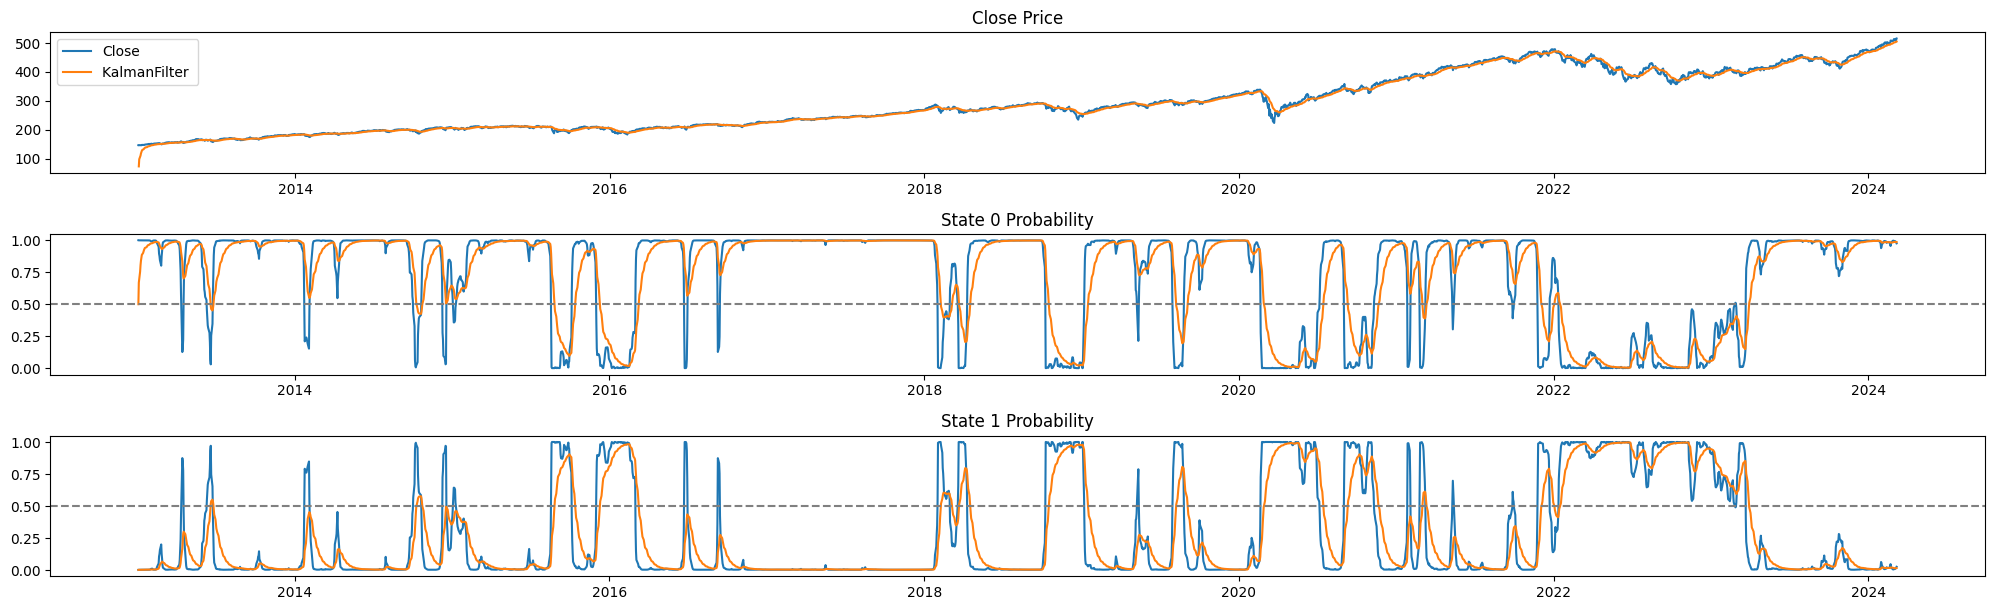

In [17]:
# Create a figure and three subplots
plt.figure(figsize=(20, 10))

# First subplot
plt.subplot(5, 1, 1)
plt.plot(spy.Close, label ="Close")
prices = df["Close"].values.astype(float)
state_means, _ = kf.filter(prices)
state_means_list = state_means.flatten().tolist()
plt.plot(spy.index[1:], state_means_list, label = "KalmanFilter ")
plt.legend()
plt.title('Close Price')

plt.subplot(5, 1, 2)
plt.plot(spy.index[1:] ,hidden_states_proba.T[0], label = "Probability")
proba_0_kalman , _ = kf.filter(hidden_states_proba.T[0] )
plt.plot(spy.index[1:]  , proba_0_kalman , label = "Kalman Filter")
plt.axhline(0.5, color='gray', linestyle='--')
plt.title('State 0 Probability')

plt.subplot(5, 1, 3)
plt.plot(spy.index[1:] ,hidden_states_proba.T[1], label = "Probability")
proba_1_kalman  , _ = kf.filter(hidden_states_proba.T[1])
plt.plot(spy.index[1:]  , proba_1_kalman , label = "Kalman Filter")
plt.axhline(0.5, color='gray', linestyle='--')
plt.title('State 1 Probability')


# Show the plot
plt.tight_layout()
plt.show()

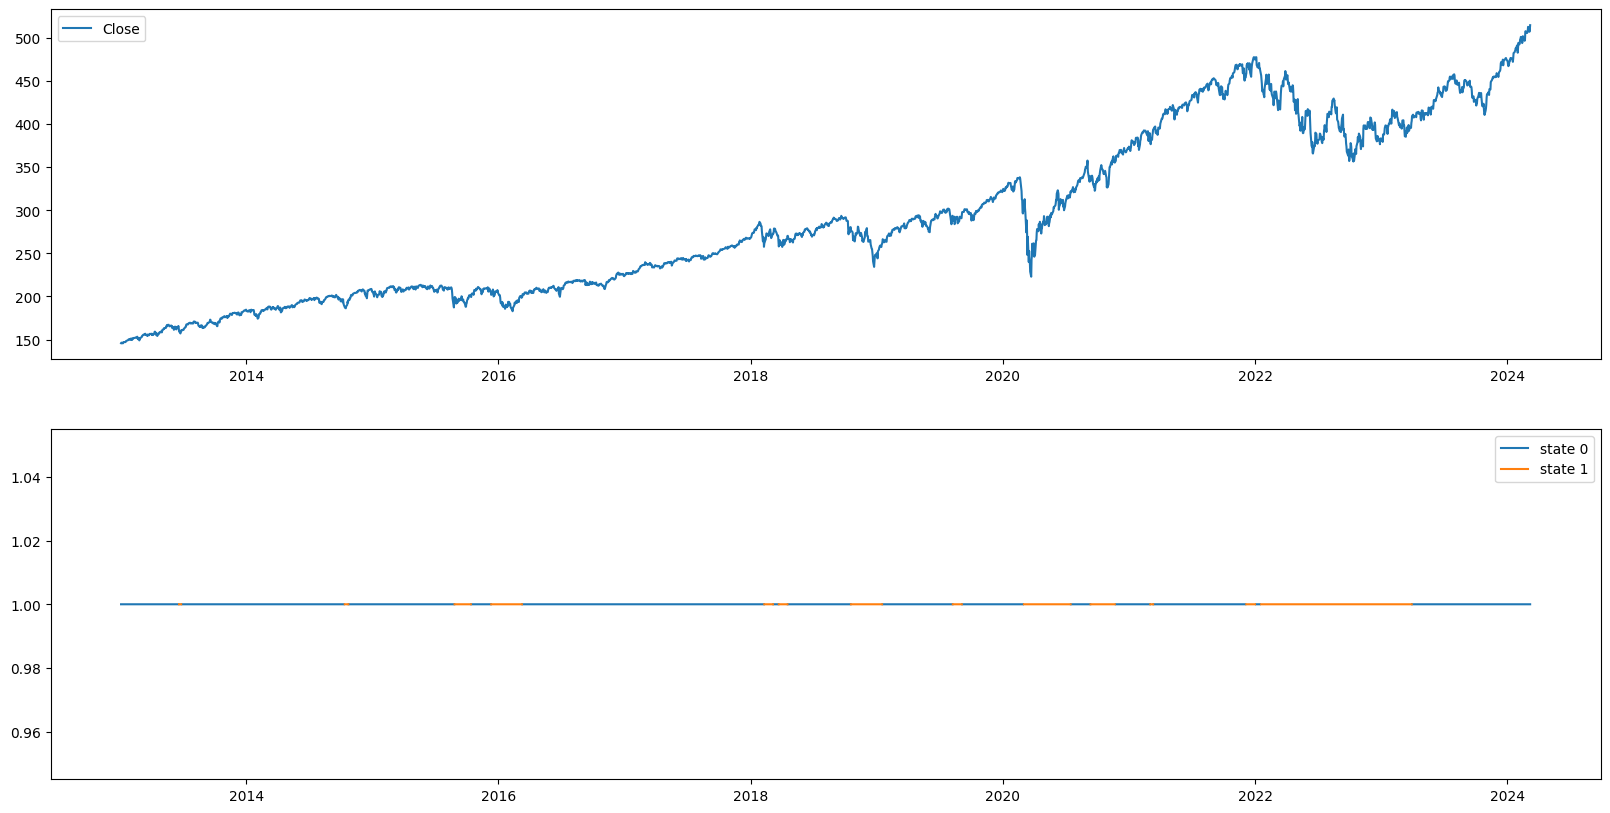

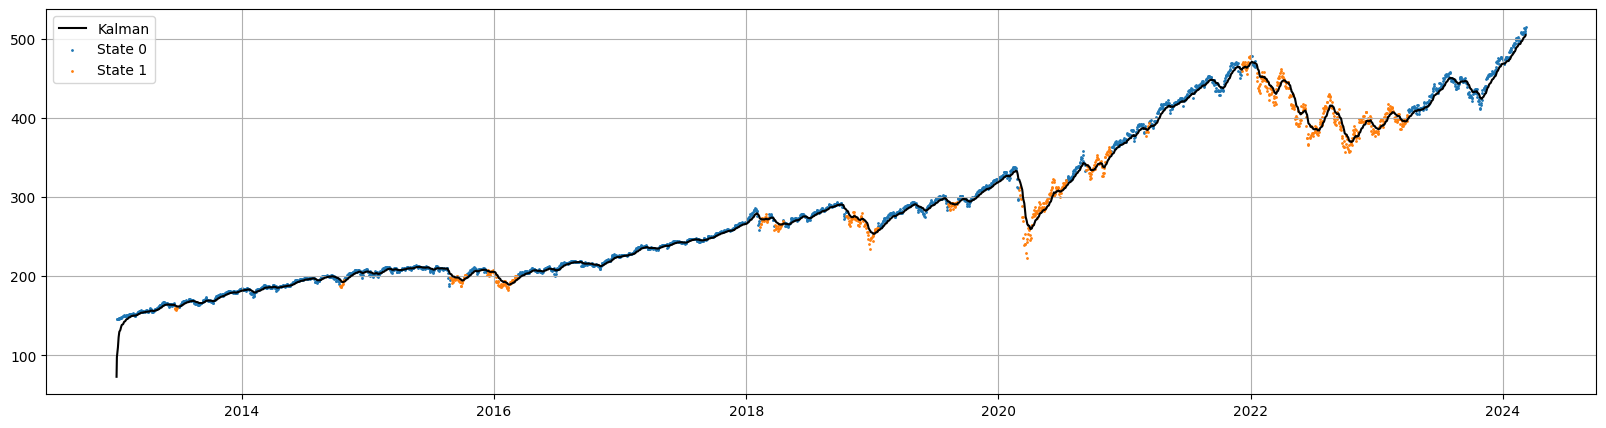

In [18]:
# Define that the asset enter a regime if filtered probability > 0.5
state_0 = np.where(proba_0_kalman >=0.5, 1, float('nan'))
state_1 = np.where(proba_1_kalman >=0.5, 1, float('nan'))


plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(spy.index[1:], spy.Close[1:], label = "Close")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(spy.index[1:], state_0, label = "state 0")
plt.plot(spy.index[1:], state_1, label = "state 1")
plt.legend()
plt.show()

df_close_state = pd.DataFrame()
df_close_state["Close"] = spy.Close[1:]
df_close_state["State 0"] = state_0
df_close_state["State 1"] = state_1


plt.figure(figsize=(20, 5))

state_means, _ = kf.filter(df_close_state.Close)
state_means_list = state_means.flatten().tolist()
plt.plot(df_close_state.index, state_means_list, label = "Kalman", c = "black")
plt.scatter(df_close_state[df_close_state["State 0"] ==1].index,df_close_state[df_close_state["State 0"] ==1].Close, label = "State 0",s = 1)
plt.scatter(df_close_state[df_close_state["State 1"] ==1].index,df_close_state[df_close_state["State 1"] ==1].Close, label = "State 1",s = 1)
plt.legend()
plt.grid()
plt.show()

In [19]:
# indication of state
df_close_state.head()

,Close,State 0,State 1
Date,,,
2013-01-03,145.729996,1.0,NaN
2013-01-04,146.369995,1.0,NaN
2013-01-07,145.970001,1.0,NaN
2013-01-08,145.550003,1.0,NaN
2013-01-09,145.919998,1.0,NaN


In [20]:
# Function to determine the state
def determine_state(row):
    for i in range(4):
        if not np.isnan(row[f'State {i}']):
            return i
    return -1

# Apply the function to each row
df_close_state['State'] = df_close_state.apply(determine_state, axis=1)

# Assuming df_close_state and state_means are already defined
state_means_list = state_means.flatten().tolist()

# Create a single figure
fig = go.Figure()

# Add line plots for state means, ma5, and ma21
fig.add_trace(go.Scatter(x=df_close_state.index, y=state_means_list, mode='lines', name='Kalman', line=dict(color='black')))
fig.add_trace(go.Scatter(x=df_close_state.index, y=df_close_state.Close.rolling(12).mean(), mode='lines', name='ma12', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_close_state.index, y=df_close_state.Close.rolling(21).mean(), mode='lines', name='ma21', line=dict(color='purple')))

state_colors = ['green', 'red', 'orange', 'yellow']

# Add scatter plots for each state
for state in range(4):
    fig.add_trace(go.Scatter(
        x=df_close_state[df_close_state["State"]==state].index,
        y=df_close_state[df_close_state["State"]==state].Close,
        mode='markers',
        marker=dict(size=5, color=state_colors[state]),
        name=f'State {state}'
    ))

# If State -1 exists
if any(df_close_state["State"] == -1):
    fig.add_trace(go.Scatter(
        x=df_close_state[df_close_state["State"]==-1].index,
        y=df_close_state[df_close_state["State"]==-1].Close,
        mode='markers',
        marker=dict(size=5),
        name='State -1'
    ))

# Update layout
fig.update_layout(
    title='Regime Visualization',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='State',
    width=1500,  # Equivalent to 30 inches
    height=600,  # Equivalent to 10 inches
    template='plotly_white'  # Adds a grid background
)

fig.show()

In [21]:
# put two states into one column
df_close_state.head()

,Close,State 0,State 1,State
Date,,,,
2013-01-03,145.729996,1.0,NaN,0
2013-01-04,146.369995,1.0,NaN,0
2013-01-07,145.970001,1.0,NaN,0
2013-01-08,145.550003,1.0,NaN,0
2013-01-09,145.919998,1.0,NaN,0


## Backtest Stratigies

In [22]:
# Strategy 1 : SMAs crossover
# Long position when fast SMA > slow SMA in bull regime
# Close position slow SMA crosses fast SMA from below or in bear regime
# Ref : https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/

# Strategy 2 : 4 SMAs crossover
# Modification of https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html
# Long position when close price crosses sma_enter in 1) bull regime and 2) fast SMA > slow SMA
# Close position when 1) sma_enter crosses close price from below, 2) sma_exit crosses close price from below or 3) in bear regime

# Strategy 3 : Kalman Filter - SMA crossover
# Long position when Kalman filter of close > SMA in bull regime
# Close position if SMA cross Kalman Filter or in bear regime

# Assume no comission, e.g. Alpaca
# 3 x leverage

# Grid Search Parameters from 2013 to 2017

In [23]:
spy["State"] = df_close_state["State"]
spy.dropna(inplace = True)

### Strategy 1 : SMAs crossover

In [24]:
def Extract(data, column):
    return data[column]

class SmaCross(Strategy):
    n1 = 12
    n2 = 21

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)
        self.state = self.I(Extract, self.data, 'State')

    def next(self):
        state = self.state[-1]

        if not self.position:
            if (self.sma1 > self.sma2) and (state ==0):
                self.buy()

        else:
            if crossover(self.sma1, self.sma2) or  (state !=0):
                self.position.close()


bt_sma2 = Backtest(spy[(spy.index < "2017-12-31")], SmaCross,
              cash=10000, commission=0,
              exclusive_orders=True, margin=0.3)

output = bt_sma2.run()
stats, heatmap = bt_sma2.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    constraint=lambda p: p.n1 < p.n2,
    maximize='Sharpe Ratio',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
heatmap.sort_values().iloc[-10:]
# n1 = 90 and n2 = 120

n1   n2 
90   140    0.717594
100  160    0.722868
     140    0.725746
70   160    0.729654
100  120    0.756880
70   120    0.757395
60   120    0.766060
10   40     0.782957
80   120    0.786403
90   120    0.812169
Name: Sharpe Ratio, dtype: float64

In [26]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,20,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,,
10,0.692782,0.782957,0.590878,0.613468,0.565402,0.658439,0.550026,0.601286,0.504174,0.544520
20,NaN,0.608980,0.551902,0.578105,0.525881,0.618374,0.515849,0.580108,0.608301,0.551658
30,NaN,0.665898,0.652834,0.587781,0.516907,0.715816,0.617301,0.633805,0.598993,0.564933
40,NaN,NaN,0.641899,0.582153,0.579508,0.618402,0.595072,0.628344,0.583567,0.555558
50,NaN,NaN,0.664206,0.638691,0.603320,0.701527,0.633813,0.679828,0.658013,0.624049
60,NaN,NaN,NaN,0.555399,0.622651,0.766060,0.705485,0.712573,0.673188,0.656070
70,NaN,NaN,NaN,0.576974,0.658807,0.757395,0.708565,0.729654,0.677160,0.664344
80,NaN,NaN,NaN,NaN,0.654979,0.786403,0.670855,0.700502,0.692447,0.657966
90,NaN,NaN,NaN,NaN,0.661253,0.812169,0.717594,0.691514,0.652675,0.628924


<Axes: xlabel='n2', ylabel='n1'>

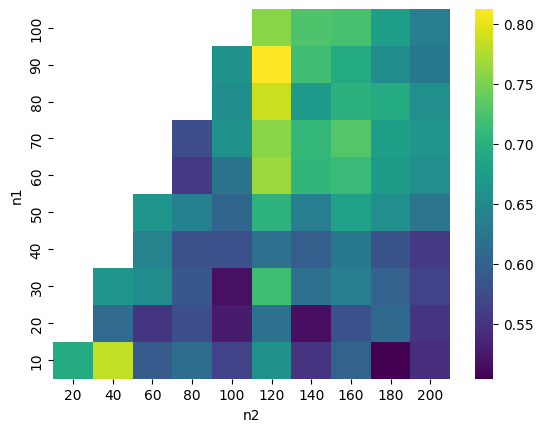

In [27]:
sns.heatmap(hm[::-1], cmap='viridis')

In [28]:
plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p1048', ...)

In [29]:
# Test Strategy from 2018
class SmaCross(Strategy):
    n1 = 90
    n2 = 120

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)
        self.state = self.I(Extract, self.data, 'State')

    def next(self):
        state = self.state[-1]

        if not self.position:
            if (self.sma1 > self.sma2) and (state ==0):
                self.buy()

        else:
            if crossover(self.sma1, self.sma2) or  (state !=0):
                self.position.close()


bt_sma2 = Backtest(spy[(spy.index > "2017-12-31")], SmaCross,
              cash=10000, commission=0,
              exclusive_orders=True, margin=0.3)

output_sma2 = bt_sma2.run()
bt_sma2.plot()

GridPlot(id='p1423', ...)

In [30]:
output_sma2

Start                     2018-01-02 00:00:00
End                       2024-03-07 00:00:00
Duration                   2256 days 00:00:00
Exposure Time [%]                   50.932476
Equity Final [$]                   36995.3125
Equity Peak [$]                    36995.3125
Return [%]                         269.953125
Buy & Hold Return [%]               91.542962
Return (Ann.) [%]                    23.61542
Volatility (Ann.) [%]               35.263681
Sharpe Ratio                         0.669681
Sortino Ratio                        1.193805
Calmar Ratio                         0.728301
Max. Drawdown [%]                  -32.425335
Avg. Drawdown [%]                   -4.918005
Max. Drawdown Duration      572 days 00:00:00
Avg. Drawdown Duration       32 days 00:00:00
# Trades                                   10
Win Rate [%]                             60.0
Best Trade [%]                      17.771922
Worst Trade [%]                     -4.400901
Avg. Trade [%]                    

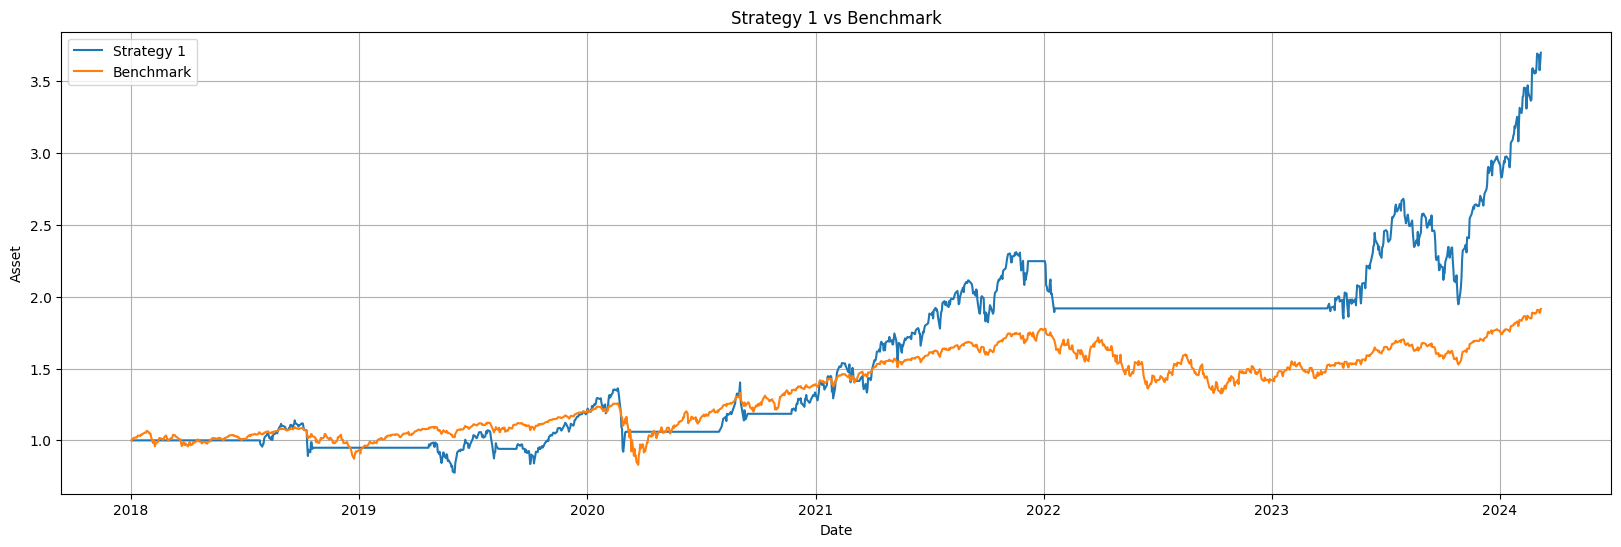

In [31]:
plt.figure(figsize = (20,6))
plt.plot(output_sma2._equity_curve.index, output_sma2._equity_curve.Equity / 10000, label = "Strategy 1")
plt.plot(spy[spy.index > "2017-12-31"].index, spy[spy.index > "2017-12-31"].Close / spy[spy.index > "2017-12-31"].Close[0] , label = "Benchmark")
plt.title("Strategy 1 vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Asset")
plt.legend()
plt.grid()
plt.show()

### Strategy 2 : 4 SMAs crossover

In [32]:
class Sma4Cross(Strategy):
    n1 = 50
    n2 = 100
    n_enter = 20
    n_exit = 10

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        self.state = self.I(Extract, self.data, 'State')

    def next(self):
        state = self.state[-1]

        if not self.position:

            # On upwards trend, if price closes above
            # "entry" MA, go long

            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if (self.sma1 > self.sma2) and (state ==0):
                #if crossover(self.data.Close, self.sma_enter):
                if self.data.Close > self.sma_enter:
                    self.buy()

            # On downwards trend, if price closes below
            # "entry" MA, go short

            else:
                if crossover(self.sma_enter, self.data.Close) or  (state !=0):
                    self.position.close()

        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position

        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)):
                #or
                #self.position.is_short and
                #crossover(self.data.Close, self.sma_exit)):

                self.position.close()

backtest_sma4 = Backtest(spy[(spy.index < "2017-12-31")], Sma4Cross, commission=.000)
stats, heatmap = backtest_sma4.optimize(
    n1=range(10, 110, 10),
    n2=range(20, 210, 20),
    n_enter=range(15, 35, 5),
    n_exit=range(10, 25, 5),
    constraint=lambda p: p.n_exit < p.n_enter < p.n1 < p.n2,
    maximize='Sharpe Ratio',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
heatmap.sort_values().iloc[-10:]

n1   n2   n_enter  n_exit
50   120  30       20        0.550171
60   160  25       20        0.561882
100  120  15       10        0.565821
          30       20        0.567462
90   120  30       20        0.569155
     160  25       20        0.571473
70   140  25       20        0.578580
100  180  25       20        0.580864
80   160  25       20        0.592316
70   160  25       20        0.599386
Name: Sharpe Ratio, dtype: float64

In [34]:
hm = heatmap.groupby(['n1', 'n2']).mean().unstack()
hm

n2,40,60,80,100,120,140,160,180,200
n1,,,,,,,,,
20,NaN,0.148062,0.232321,0.131849,NaN,NaN,NaN,NaN,NaN
30,0.118369,0.192669,0.263212,0.092408,0.230658,0.310474,0.363348,0.240343,0.212123
40,NaN,0.332115,NaN,0.036821,0.324624,0.298702,0.386169,0.225631,0.211585
50,NaN,0.220257,0.243718,0.191363,0.477122,0.321445,0.342189,0.282648,0.244579
60,NaN,NaN,0.136550,0.263380,0.378205,0.289872,0.424568,0.535193,0.214846
70,NaN,NaN,0.000000,0.209965,0.431393,0.578580,0.431731,0.335005,0.275272
80,NaN,NaN,NaN,0.373411,0.378423,0.352086,0.375516,0.339044,0.321763
90,NaN,NaN,NaN,0.393939,0.423394,0.399250,0.393130,0.492078,0.308106
100,NaN,NaN,NaN,NaN,0.470411,0.416903,0.366894,0.354874,0.208631


<Axes: xlabel='n2', ylabel='n1'>

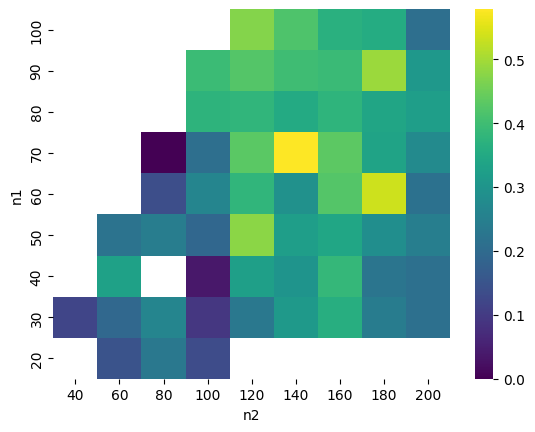

In [35]:
sns.heatmap(hm[::-1], cmap='viridis')

In [36]:
plot_heatmaps(heatmap, agg='mean')

GridPlot(id='p1724', ...)

In [37]:
# Test Strategy from 2018
class Sma4Cross(Strategy):
    #n1 = 80
    #n2 = 100
    #n_enter = 25
    #n_exit = 20
    n1 , n2 , n_enter , n_exit = 70 ,120 ,20 ,25

    def init(self):
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
        self.sma_enter = self.I(SMA, self.data.Close, self.n_enter)
        self.sma_exit = self.I(SMA, self.data.Close, self.n_exit)
        self.state = self.I(Extract, self.data, 'State')

    def next(self):
        state = self.state[-1]

        if not self.position:

            # On upwards trend, if price closes above
            # "entry" MA, go long

            # Here, even though the operands are arrays, this
            # works by implicitly comparing the two last values
            if (self.sma1 > self.sma2) and (state ==0):
                #if crossover(self.data.Close, self.sma_enter):
                if self.data.Close > self.sma_enter:
                    self.buy()

            # On downwards trend, if price closes below
            # "entry" MA, go short

            else:
                if crossover(self.sma_enter, self.data.Close) or  (state !=0):
                    self.position.close()

        # But if we already hold a position and the price
        # closes back below (above) "exit" MA, close the position

        else:
            if (self.position.is_long and
                crossover(self.sma_exit, self.data.Close)
                or
                self.position.is_short and
                crossover(self.data.Close, self.sma_exit)):

                self.position.close()


backtest_sma4 = Backtest(spy[spy.index > "2018-01-01"], Sma4Cross, commission=.000, margin=0.3)
output_sma4 = backtest_sma4.run()
backtest_sma4.plot()

GridPlot(id='p2129', ...)

In [38]:
output_sma4

Start                     2018-01-02 00:00:00
End                       2024-03-07 00:00:00
Duration                   2256 days 00:00:00
Exposure Time [%]                   43.601286
Equity Final [$]                 38233.818054
Equity Peak [$]                  38233.818054
Return [%]                         282.338181
Buy & Hold Return [%]               91.542962
Return (Ann.) [%]                   24.276849
Volatility (Ann.) [%]               26.109867
Sharpe Ratio                         0.929796
Sortino Ratio                        1.643633
Calmar Ratio                         0.978489
Max. Drawdown [%]                  -24.810561
Avg. Drawdown [%]                   -4.165297
Max. Drawdown Duration      607 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                   31
Win Rate [%]                        51.612903
Best Trade [%]                      18.469778
Worst Trade [%]                     -2.506993
Avg. Trade [%]                    

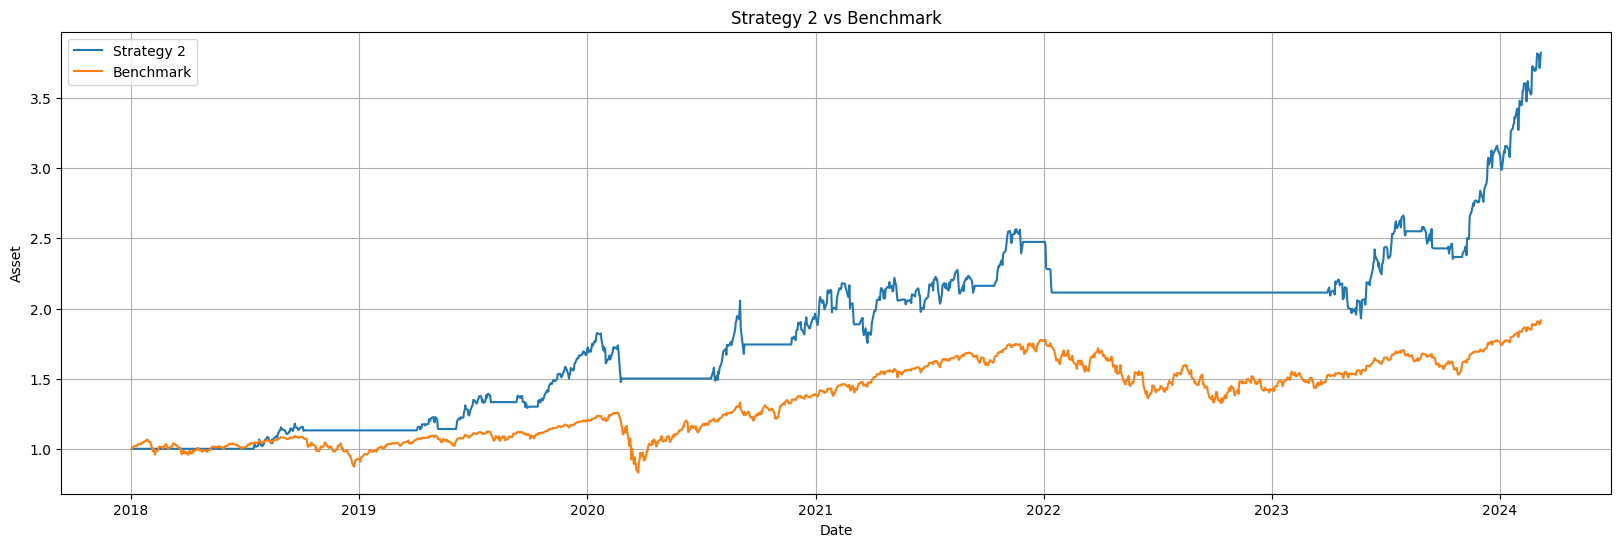

In [39]:
plt.figure(figsize = (20,6))
plt.plot(output_sma4._equity_curve.index, output_sma4._equity_curve.Equity / 10000, label = "Strategy 2")
plt.plot(spy[spy.index > "2018-01-01"].index, spy[spy.index > "2018-01-01"].Close / spy[spy.index > "2018-01-01"].Close[0] , label = "Benchmark")
plt.title("Strategy 2 vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Asset")
plt.legend()
plt.grid()
plt.show()

### Strategy 3 : Kalman Filter - SMA crossover

In [40]:
# Kalman filter for close price
spy_kalman = spy.copy()
state_means, _ = kf.filter(spy_kalman.Close)
state_means_list = state_means.flatten().tolist()
spy_kalman["Kalman"] = state_means_list
spy_kalman = spy_kalman[spy_kalman.index > "2013-12-31"]

In [41]:
spy_kalman

,Open,High,Low,Close,Adj Close,Volume,State,Kalman
Date,,,,,,,,
2014-01-02,183.979996,184.070007,182.479996,182.919998,152.669113,119636900,0.0,181.690208
2014-01-03,183.229996,183.600006,182.630005,182.889999,152.644104,81390600,0.0,181.804338
2014-01-06,183.490005,183.559998,182.080002,182.360001,152.201767,108028200,0.0,181.857195
2014-01-07,183.089996,183.789993,182.949997,183.479996,153.136475,86144200,0.0,182.011564
2014-01-08,183.449997,183.830002,182.889999,183.520004,153.169922,96582300,0.0,182.155054
...,...,...,...,...,...,...,...,...
2024-03-01,508.980011,513.289978,508.559998,512.849976,512.849976,76805900,0.0,500.863817
2024-03-04,512.030029,514.200012,512.000000,512.299988,512.299988,49799300,0.0,501.951682
2024-03-05,510.239990,510.700012,504.910004,507.179993,507.179993,72855600,0.0,502.449024


In [42]:
class KalmanSmaCross(Strategy):
    n = 12

    def init(self):
        close = self.data.Close
        self.sma = self.I(SMA, close, self.n)
        self.state = self.I(Extract, self.data, 'State')
        self.kalman = self.I(Extract, self.data, 'Kalman')

    def next(self):
        state = self.state[-1]

        if not self.position:
            if (self.kalman > self.sma) and (state ==0):
                self.buy()

        else:
            if crossover(self.sma, self.kalman) or  (state !=0):
                self.position.close()


bt_kalman = Backtest(spy_kalman[(spy_kalman.index < "2017-12-31")], KalmanSmaCross,
              cash=10000, commission=0,
              exclusive_orders=True, margin=0.3)

output_kalman = bt_kalman.run()
stats, heatmap = bt_kalman.optimize(
    n=range(10, 110, 10),
    #constraint=lambda p: p.n1 < p.n2,
    maximize='Sharpe Ratio',
    max_tries=200,
    random_state=0,
    return_heatmap=True)

Backtest.optimize:   0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
heatmap.sort_values().iloc[-10:]

n  
40     0.187508
30     0.369110
50     0.420655
100    0.469063
60     0.470081
10     0.505390
20     0.521897
90     0.540165
70     0.629302
80     0.649058
Name: Sharpe Ratio, dtype: float64

In [44]:
class KalmanSmaCross(Strategy):
    n = 80

    def init(self):
        close = self.data.Close
        self.sma = self.I(SMA, close, self.n)
        self.state = self.I(Extract, self.data, 'State')
        self.kalman = self.I(Extract, self.data, 'Kalman')

    def next(self):
        state = self.state[-1]

        if not self.position:
            if (self.kalman > self.sma) and (state ==0):
                self.buy()

        else:
            if crossover(self.sma, self.kalman) or  (state !=0):
                self.position.close()


bt_kalman = Backtest(spy_kalman[(spy_kalman.index > "2017-12-31")], KalmanSmaCross,
              cash=10000, commission=0,
              exclusive_orders=True, margin=0.3)
output_kalman = bt_kalman.run()
bt_kalman.plot()

GridPlot(id='p2532', ...)

In [45]:
output_kalman

Start                     2018-01-02 00:00:00
End                       2024-03-07 00:00:00
Duration                   2256 days 00:00:00
Exposure Time [%]                   54.083601
Equity Final [$]                 35564.805542
Equity Peak [$]                  35564.805542
Return [%]                         255.648055
Buy & Hold Return [%]               91.542962
Return (Ann.) [%]                    22.82795
Volatility (Ann.) [%]                34.73669
Sharpe Ratio                         0.657171
Sortino Ratio                        1.155988
Calmar Ratio                         0.700016
Max. Drawdown [%]                  -32.610618
Avg. Drawdown [%]                    -4.81493
Max. Drawdown Duration      572 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                   12
Win Rate [%]                        83.333333
Best Trade [%]                      13.230951
Worst Trade [%]                     -4.400901
Avg. Trade [%]                    

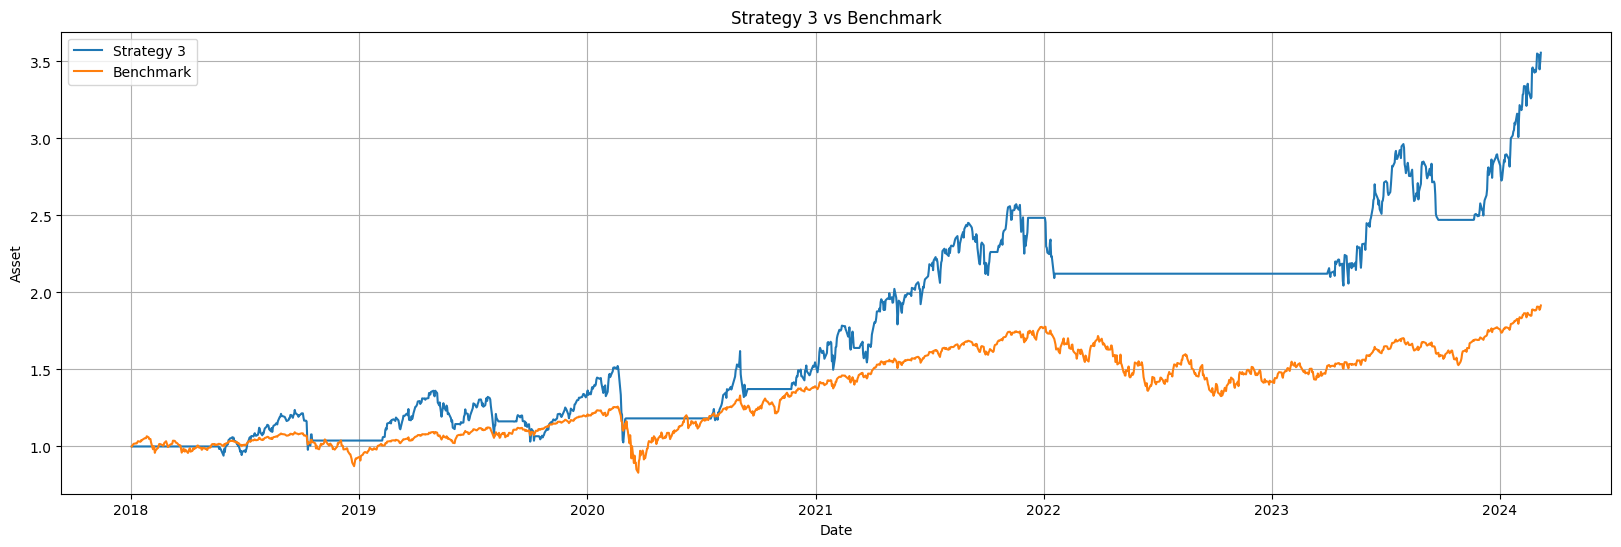

In [46]:
plt.figure(figsize = (20,6))
plt.plot(output_kalman._equity_curve.index, output_kalman._equity_curve.Equity / 10000, label = "Strategy 3")
plt.plot(spy_kalman[spy_kalman.index > "2018-01-01"].index, spy_kalman[spy_kalman.index > "2018-01-01"].Close / spy_kalman[spy_kalman.index > "2018-01-01"].Close[0] , label = "Benchmark")
plt.title("Strategy 3 vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Asset")
plt.legend()
plt.grid()
plt.show()

In [47]:
# Calculate Sharpe Ratio of SPY from 2018 on
spy_prices = spy[spy.index > "2018-01-01"].copy()

# Calculate daily log returns
spy_prices['return'] = spy_prices['Close'] / spy_prices['Close'].shift(1) -1

# Annualize the average log return
mean_return_daily = spy_prices['return'].mean()
mean_return_annualized = mean_return_daily * 252  # Assuming 252 trading days in a year

# Risk-free rate
risk_free_rate = 0  # Take risk free rate as 0

# Calculate the standard deviation of the daily returns
std_deviation_daily = spy_prices['return'].std()
std_deviation_annualized = std_deviation_daily * np.sqrt(252)

# Calculate the Sharpe Ratio
sharpe_ratio = (mean_return_annualized - risk_free_rate) / std_deviation_annualized

print("Sharpe Ratio of Benchmark (SPY):", sharpe_ratio)

Sharpe Ratio of Benchmark (SPY): 0.6220482700533883


In [48]:
# Calculate MDD of SPY from 2018 on
close_price = spy_prices.Close

def calculate_mdd(prices):
    max_drawdown = 0
    peak = prices[0]

    for price in prices:
        if price > peak:
            peak = price
        drawdown = (peak - price) / peak
        max_drawdown = max(max_drawdown, drawdown)

    return max_drawdown
mdd = calculate_mdd(close_price)
print(f"Maximum Drawdown of Benchmark (SPY): {mdd * 100:.2f}%")

Maximum Drawdown of Benchmark (SPY): 34.10%


## Conclusion

In [49]:
sharpe_strategy_1 = output_sma2["Sharpe Ratio"]
sharpe_strategy_2 = output_sma4["Sharpe Ratio"]
sharpe_strategy_3 = output_kalman["Sharpe Ratio"]
print(f"Sharpe Ratio of Benchmark(SPY) : {sharpe_ratio}")
print(f"Sharpe Ratio of Strategy 1 : {sharpe_strategy_1}")
print(f"Sharpe Ratio of Strategy 2 : {sharpe_strategy_2}")
print(f"Sharpe Ratio of Strategy 3 : {sharpe_strategy_3}")

Sharpe Ratio of Benchmark(SPY) : 0.6220482700533883
Sharpe Ratio of Strategy 1 : 0.6696810693455783
Sharpe Ratio of Strategy 2 : 0.9297959765166186
Sharpe Ratio of Strategy 3 : 0.6571711301232631


In [50]:
MDD_strategy_1 = output_sma2["Max. Drawdown [%]"] / -100
MDD_strategy_2 = output_sma4["Max. Drawdown [%]"] / -100
MDD_strategy_3 = output_kalman["Max. Drawdown [%]"] / -100
print(f"MDD of Benchmark(SPY) : {mdd}")
print(f"MDD of Strategy 1 : {MDD_strategy_1}")
print(f"MDD of Strategy 2 : {MDD_strategy_2}")
print(f"MDD of Strategy 3 : {MDD_strategy_3}")

MDD of Benchmark(SPY) : 0.3410474689324395
MDD of Strategy 1 : 0.32425334905180203
MDD of Strategy 2 : 0.2481056115562401
MDD of Strategy 3 : 0.3261061847124795


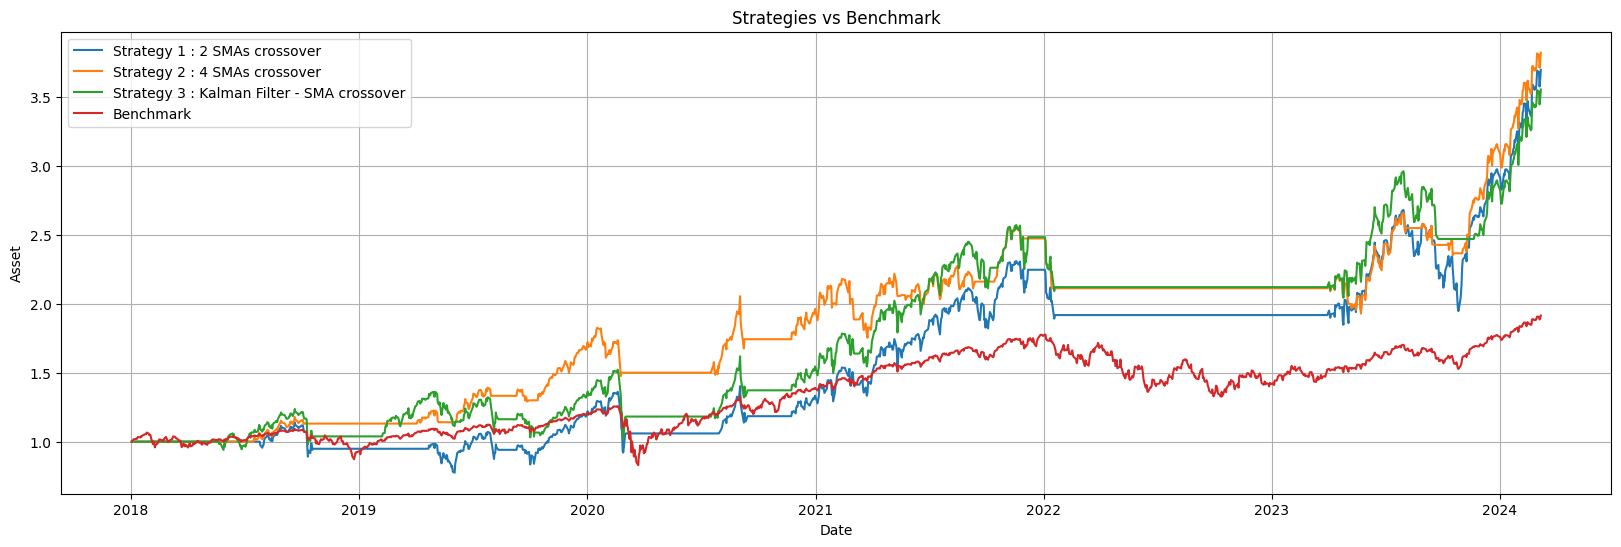

In [51]:
plt.figure(figsize = (20,6))
plt.plot(output_sma2._equity_curve.index, output_sma2._equity_curve.Equity / 10000, label = "Strategy 1 : 2 SMAs crossover ")
plt.plot(output_sma4._equity_curve.index, output_sma4._equity_curve.Equity / 10000, label = "Strategy 2 : 4 SMAs crossover")
plt.plot(output_kalman._equity_curve.index, output_kalman._equity_curve.Equity / 10000, label = "Strategy 3 : Kalman Filter - SMA crossover")
plt.plot(spy_kalman[spy_kalman.index > "2018-01-01"].index, spy_kalman[spy_kalman.index > "2018-01-01"].Close / spy_kalman[spy_kalman.index > "2018-01-01"].Close[0] , label = "Benchmark")
plt.title("Strategies vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Asset")
plt.legend()
plt.grid()
plt.show()

In [52]:
## Strategy 2 should be chosen based on Sharpe Ratio and MDD